# Sistem Rekomendasi Film - Gratia Yudika Morado Silalahi


# Import Library yang Digunakan

In [3]:
import pandas as pd  # manipulasi data
import matplotlib.pyplot as plt  # visualisasi data
import seaborn as sns  # visualisasi statistik
import numpy as np  # operasi numerik

import tensorflow as tf  # library deep learning
from tensorflow import keras  # API untuk model
from tensorflow.keras import layers  # komponen layer jaringan

from sklearn.feature_extraction.text import TfidfVectorizer  # ubah teks ke vektor TF-IDF
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel  # hitung kemiripan antar item

# Data Understanding

## Load Dataset

In [4]:
# Konversi data film ke dalam DataFrame
film_df = pd.read_csv('movies.csv', on_bad_lines='skip')
film_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
# konversi data rating ke dalam Dataframe
rating_df = pd.read_csv('ratings.csv', on_bad_lines='skip')
rating_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
# Pemeriksaan jumlah film
print('Jumlah film: ',len(film_df.movieId.unique()))
print('Jumlah rating: ',len(rating_df.userId.unique()))

Jumlah film:  9742
Jumlah rating:  610


Informasi pemahaman data
Dataset yang digunakan diambil dari repository kaggle dengan informasi berikut.
- Nama file: Movies & Ratings for Recommendation System
- Author: Nicoleta Cilibiu
- Tautan: https://www.kaggle.com/datasets/nicoletacilibiu/movies-and-ratings-for-recommendation-system



# Exploratory Data Analysis

## Deskripsi Variabel

In [7]:
print("Informasi DataFrame Film")
print("=" * 35)
film_df.info()
print("\n")  # baris kosong untuk pemisah

print("Informasi DataFrame Rating")
print("=" * 38)
rating_df.info()

Informasi DataFrame Film
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


Informasi DataFrame Rating
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


Dataframe film memuat 3 variabel di dalamnya, yakni dengan 1 integer pada movieid dan 2 teks pada title dan genres. Pada dataframe rating, variabel yang dimuat yakni 3 integer: userID, movieID, dan timestamp serta float untuk rating.

Sejauh ini diketahui tidak ada missing value dalam dataset, namun untuk outlier dan duplikasi akan diperiksa selanjutnya.

## Penggambaran data


In [8]:
# Deskripsi Dataset Film
print("Penggambaran DataFrame Film")
print("=" * 20)
film_df.describe()

Penggambaran DataFrame Film


,movieId
count,9742.000000
mean,42200.353623
std,52160.494854
min,1.000000
25%,3248.250000
50%,7300.000000
75%,76232.000000
max,193609.000000


- ID film dimulai dari 1 hingga 193.609, menunjukkan bahwa movieId tidak berurutan dan kemungkinan besar mengandung celah (gap) antar ID.
- Nilai tengah (median) movieId adalah 7.300, tetapi nilai maksimum jauh lebih tinggi, menandakan distribusi miring ke kanan (right-skewed) — sebagian besar film memiliki movieId lebih kecil dibanding outlier di ujung atas.

In [9]:
# Deskripsi Dataset Rating
print("Penggambaran DataFrame Rating")
print("=" * 63)
rating_df.describe()

Penggambaran DataFrame Rating


,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


- Jumlah pengguna: antara userId 1 hingga 610 — menandakan ada 610 pengguna unik.
- Nilai rating berada pada rentang 0.5 hingga 5.0, dengan rata-rata ~3.5, menunjukkan bahwa pengguna cenderung memberi rating netral hingga positif.
- Variasi rating (std = 1.04) cukup rendah → mayoritas rating terpusat di sekitar nilai tengah.
- Timestamp menunjukkan rentang waktu yang luas: dari sekitar 1996 hingga 2018, menunjukkan data historis yang panjang, cocok untuk analisis temporal (misalnya, perubahan preferensi film dari waktu ke waktu).

## Pemeriksaan missing value, data outlier dan duplikat


### Missing Value

In [10]:
print("Pemeriksaan Nilai yang hilang")
Film_hilang = film_df.isnull().sum()
print('Film: ', Film_hilang)

missing_values_rating = rating_df.isnull().sum()
print('Rating: ', missing_values_rating)

Pemeriksaan Nilai yang hilang
Film:  movieId    0
title      0
genres     0
dtype: int64
Rating:  userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


Tidak ada data yang hilang

### Outlier

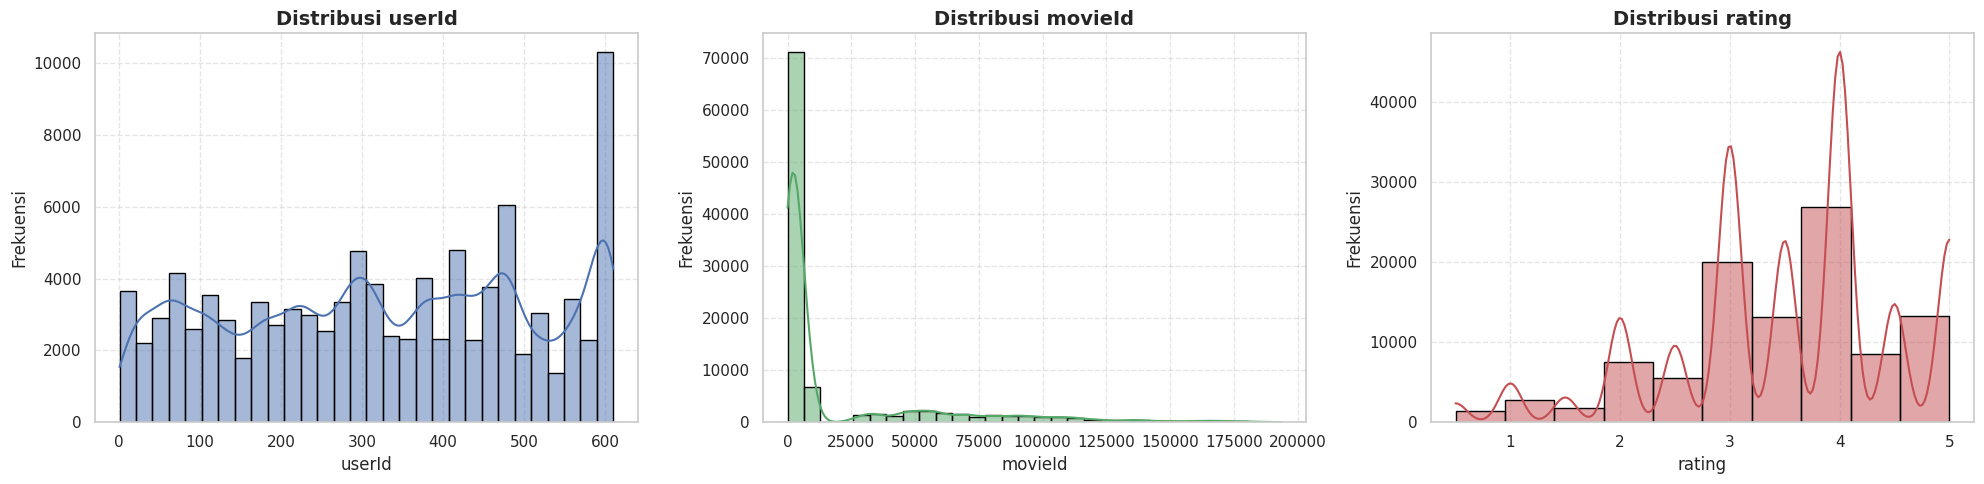

In [11]:
# Visualisasi histogram
cols = ['userId', 'movieId', 'rating']

# Set gaya visual
sns.set(style="whitegrid")

# Warna berbeda untuk tiap kolom
colors = ['#4C72B0', '#55A868', '#C44E52']

# Buat subplot 1 baris 3 kolom
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Loop setiap kolom dan buat histogram-nya
for i, col in enumerate(cols):
    bins = 30 if col != 'rating' else 10  # rating lebih sempit skalanya
    sns.histplot(
        data=rating_df,
        x=col,
        bins=bins,
        kde=True,
        ax=axes[i],
        color=colors[i],
        edgecolor='black'
    )
    axes[i].set_title(f'Distribusi {col}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frekuensi')
    axes[i].grid(True, linestyle='--', alpha=0.5)

# Tata letak agar tidak tumpang tindih
plt.tight_layout()
plt.show()

Dari yang kita lihat, data moveID sangat tidak merata penyebarannya apalagi dengan visualisasi yang menunjukkan data sangat right skewed. Tapi pengolahan tetap dapat dilanjutkan karena tidak ada bukti yang kuat bahwa data tersebut memiliki outlier pada datasetnya.

### Duplikat

In [12]:
print("Jumlah data yang duplikat")

# data duplikat Film
jumlah_duplikat_film = film_df.duplicated().sum()
print('Film: ', jumlah_duplikat_film)

# data duplikat rating
jumlah_duplikat_rating = rating_df.duplicated().sum()
print('Rating', jumlah_duplikat_rating)

Jumlah data yang duplikat
Film:  0
Rating 0


Karena tidak ada data yang duplikat, maka akan dicoba untuk memeriksa dari id nya.

In [13]:
print("Jumlah data yang unik")

# Jumlah data unik di kolom title
unique_titles = film_df['title'].nunique()
print('Judul :', unique_titles)

# Jumlah data unik di kolom movieId
unique_movieIds = film_df['movieId'].nunique()
print('movieId:', unique_movieIds)

Jumlah data yang unik
Judul : 9737
movieId: 9742


Karena jumlahnya berbeda maka akan diperiksa berdasarkan movieID setiap judul film yang terkait.

In [14]:
duplicates = film_df.groupby('title')['movieId'].nunique()
duplicates = duplicates[duplicates > 1]
print(duplicates)

title
Confessions of a Dangerous Mind (2002)    2
Emma (1996)                               2
Eros (2004)                               2
Saturn 3 (1980)                           2
War of the Worlds (2005)                  2
Name: movieId, dtype: int64


Dan dugaan benar, secara pengolahan awal tidak terdapat data yang duplikat. Namun jika melihat kecocokan ID, maka beberapa film ditemukan dengan ID yang tidaklah sama. Sehingga beberapa film pun terindikasi duplikat.

## Analisis data tunggal - Univariate

### Analisis Distribusi Genre Film

📊 Jumlah genre: 20



<ipython-input-15-ee0b69972b6b>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='viridis')


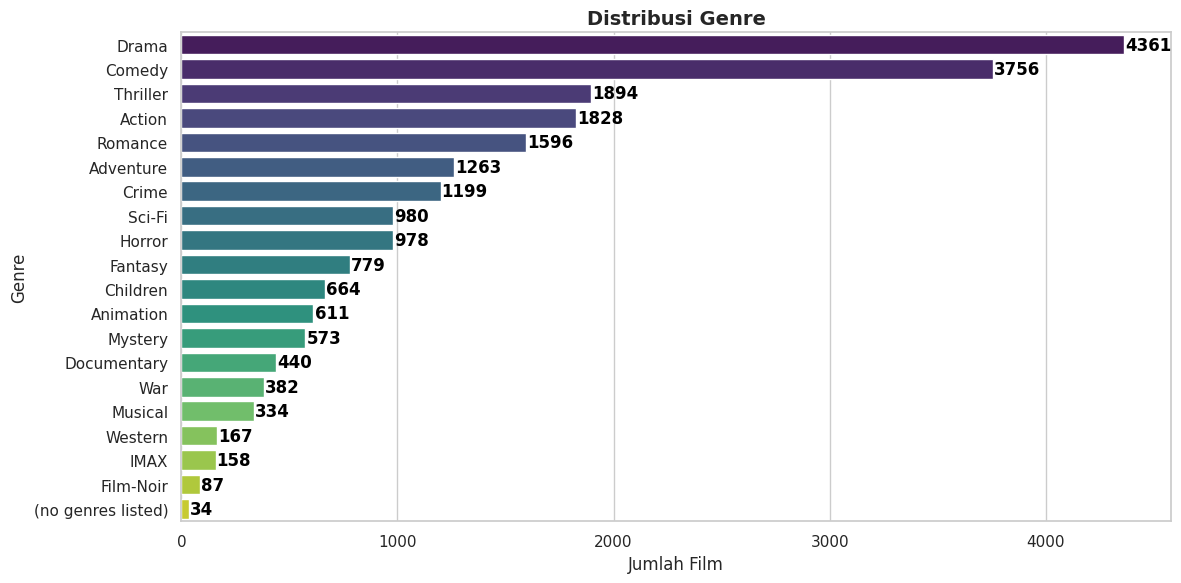

In [15]:
# Mengurai genre menjadi satu per baris
all_genres = film_df['genres'].str.split('|').explode()

# Hitung jumlah genre unik
unique_genres = all_genres.unique()
print(f'📊 Jumlah genre: {len(unique_genres)}\n')

# Hitung jumlah film per genre
genre_counts = all_genres.value_counts()

# Visualisasi dengan barplot dan anotasi jumlah film
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='viridis')

plt.title('Distribusi Genre', fontsize=14, fontweight='bold')
plt.xlabel('Jumlah Film')
plt.ylabel('Genre')

# Tambahkan angka jumlah film di samping bar
for i, v in enumerate(genre_counts.values):
    ax.text(v + 5, i, str(v), color='black', va='center', fontweight='bold')

plt.tight_layout()
plt.show()


Berdasarkan eksplorasi awal terhadap kolom genres, ditemukan bahwa dataset ini memuat sebanyak 20 genre unik. Genre Drama menjadi yang paling dominan dalam koleksi film yang tersedia, disusul oleh Comedy dan Thriller sebagai genre terbanyak berikutnya. Di sisi lain, terdapat beberapa genre yang jarang muncul, seperti Film-Noir dan Western, yang hanya diwakili oleh sedikit film.

Menariknya, terdapat 34 film yang tidak memiliki informasi genre sama sekali. Karena proyek ini akan membangun sistem rekomendasi berbasis konten (content-based filtering) yang bergantung pada atribut genre sebagai fitur utama, maka film-film tanpa genre ini sebaiknya dikeluarkan dari analisis untuk menjaga konsistensi dan keakuratan hasil model.

### Analisis Distribusi Rating Pengguna

<ipython-input-16-989259b7f746>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='rating', data=rating_df, palette='magma')


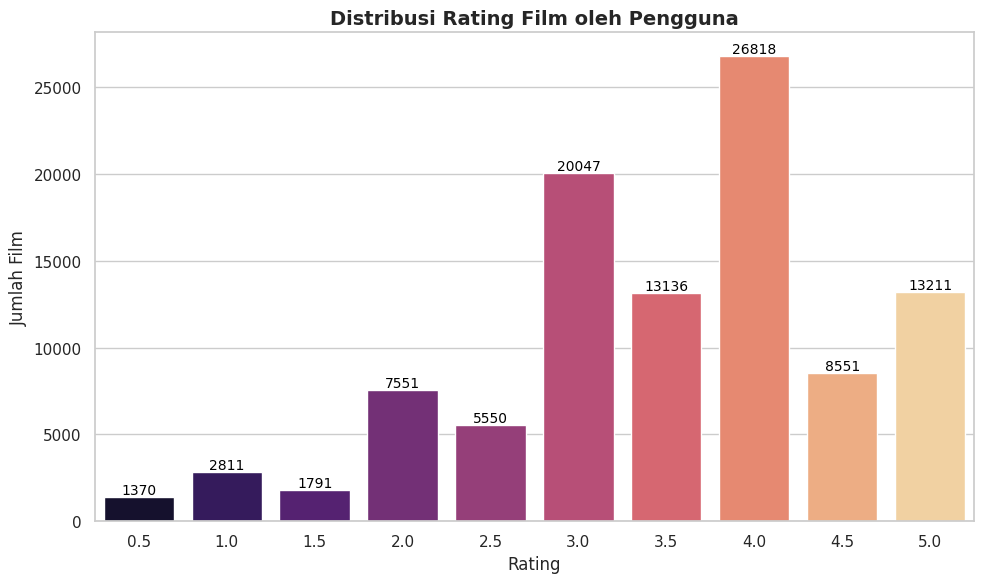

In [16]:
# Set gaya visual
sns.set(style="whitegrid")

# Ukuran figure
plt.figure(figsize=(10, 6))

# Plot distribusi rating
ax = sns.countplot(x='rating', data=rating_df, palette='magma')

# Tambahkan judul dan label sumbu
plt.title('Distribusi Rating Film oleh Pengguna', fontsize=14, fontweight='bold')
plt.xlabel('Rating')
plt.ylabel('Jumlah Film')
plt.xticks(rotation=0)

# Tambahkan angka jumlah di atas setiap bar
for p in ax.patches:
    height = int(p.get_height())
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10, color='black')

# Tata letak agar rapi
plt.tight_layout()
plt.show()


Mayoritas pengguna cenderung memberikan penilaian di kisaran **moderat**, yakni antara **3.0 hingga 4.0**, dengan **rating 4.0** menjadi yang paling sering diberikan. Sementara itu, **rating sempurna (5.0)** juga cukup banyak muncul, menunjukkan bahwa pengguna relatif sering memberikan apresiasi tinggi, terutama jika dibandingkan dengan frekuensi rating rendah yang lebih jarang diberikan.


### Distribusi Film Dengan Akumulasi Rating - Top 20 rating tertinggi

<ipython-input-17-7f0ebdcba776>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='rating_count', y='title', data=top20_most_rated, palette='Blues_d')


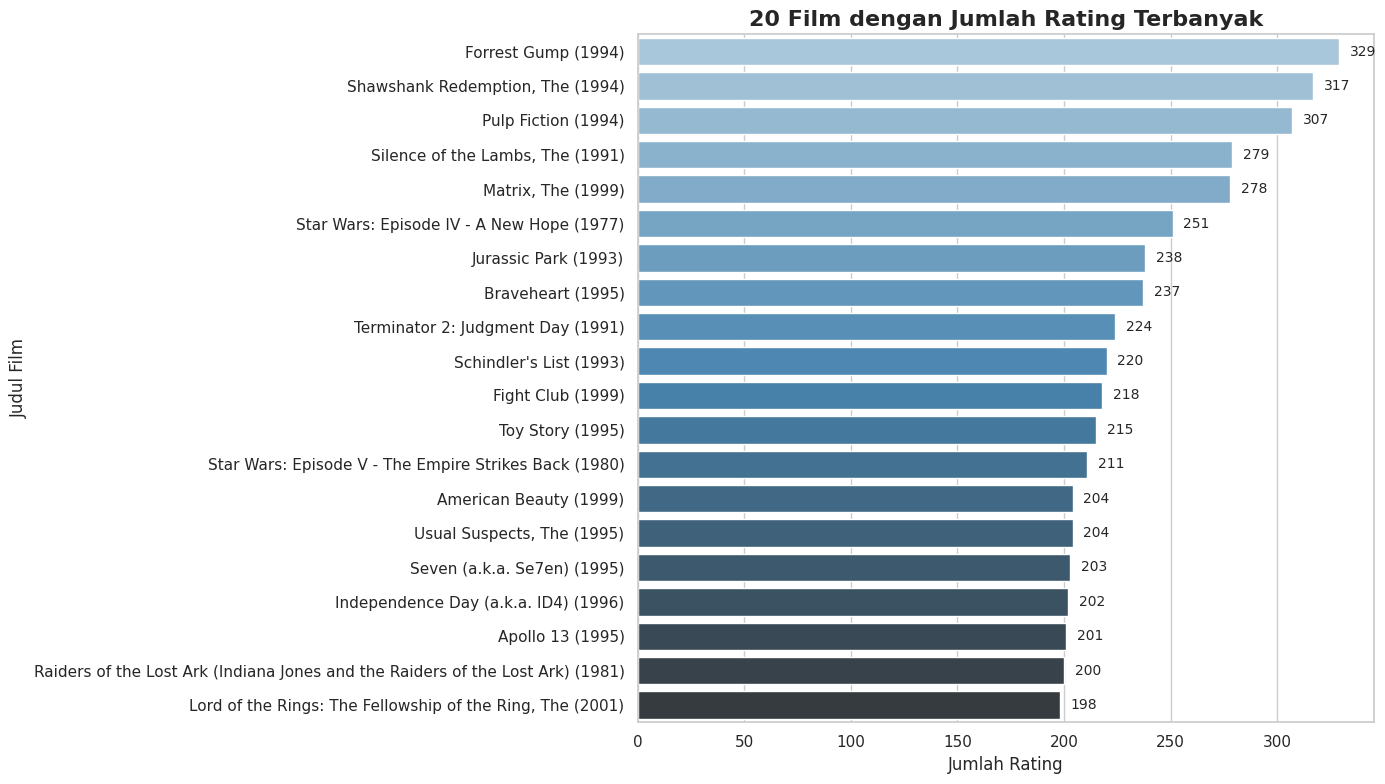

In [17]:
# Hitung jumlah rating per film
rating_counts = rating_df.groupby('movieId').size().reset_index(name='rating_count')

# Gabungkan dengan movies_df agar dapat judul film
movie_rating_counts = rating_counts.merge(film_df[['movieId', 'title']], on='movieId')

# Urutkan berdasarkan rating_count terbesar dan ambil 20 teratas
top20_most_rated = movie_rating_counts.sort_values(by='rating_count', ascending=False).head(20)

# Visualisasi dengan bar chart horizontal seaborn
plt.figure(figsize=(14, 8))
ax = sns.barplot(x='rating_count', y='title', data=top20_most_rated, palette='Blues_d')

plt.title('20 Film dengan Jumlah Rating Terbanyak', fontsize=16, fontweight='bold')
plt.xlabel('Jumlah Rating', fontsize=12)
plt.ylabel('Judul Film', fontsize=12)

# Tambahkan anotasi jumlah rating di ujung bar
for i, count in enumerate(top20_most_rated['rating_count']):
    ax.text(count + 5, i, str(count), va='center', fontsize=10)

plt.tight_layout()
plt.show()


Tahun 1990-an menjadi tahun terbanyak dari 20 film terbaik yang ada. Faktor bahwa di zaman itu hiburan belum terlalu bervariasi menjadi salah 1 faktor terkuat dari analisis tersebut

# Data Preparation

## Data Film

Hapus film dengan genre 'no genres listed'

In [18]:
# Hapus baris yang kolom 'genres' berisi '(no genres listed)'
fix_movie = film_df[film_df['genres'] != '(no genres listed)'].copy()

# Cek hasil
print(f"Sebelum: {len(film_df)} baris")
print(f"Setelah: {len(fix_movie)} baris")


Sebelum: 9742 baris
Setelah: 9708 baris


Hapus film dengan judul yang duplikat

In [19]:
fix_movie = fix_movie.drop_duplicates(subset='title', keep='first')
duplicates = fix_movie.groupby('title')['movieId'].nunique()
duplicates = duplicates[duplicates > 1]
print(duplicates)

Series([], Name: movieId, dtype: int64)


Film dan rating digabungkan

In [20]:
merged_df = pd.merge(
    rating_df,
    film_df,
    on='movieId',
    how='left'
    )
merged_df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


## Data Preparation untuk Content-based Filtering

In [21]:
# mengonversi setiap data series 'movieId' menjadi bentuk list
moviesId = fix_movie['movieId'].tolist()

# mengonversi data 'title' menjadi bentuk list
title = fix_movie['title'].tolist()

# mengonversi data 'genres' menjadi bentuk list
genres = fix_movie['genres'].tolist()

print(len(moviesId))
print(len(title))
print(len(genres))

9703
9703
9703


In [22]:
# Membuat dictionary untuk data ‘moviesId’, ‘title’, dan ‘genres’
movies_new = pd.DataFrame({
    'moviesId': moviesId,
    'title': title,
    'genres': genres
})
movies_new

,moviesId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9698,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9699,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9700,193585,Flint (2017),Drama
9701,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


Insight penting dalam pengolahan data film adalah pembuatan dictionary yang berfungsi untuk memetakan pasangan key-value antara movieId, title, dan genres. Dengan menggunakan dictionary ini, setiap movieId unik akan menjadi kunci (key) yang terhubung langsung dengan nilai (value) berupa judul film (title) dan kategori genre (genres)

In [23]:
# membuat salinan dari data movies
data_movies = movies_new

### TF_IDF Vectorizer

In [24]:
# Inisialisasi TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')

tfidf_matrix = tfidf.fit_transform(data_movies['genres'])

tfidf.get_feature_names_out()

array(['action', 'adventure', 'animation', 'children', 'comedy', 'crime',
       'documentary', 'drama', 'fantasy', 'fi', 'film', 'horror', 'imax',
       'musical', 'mystery', 'noir', 'romance', 'sci', 'thriller', 'war',
       'western'], dtype=object)

Insight penting dalam pemrosesan data genre film adalah mengubah teks genre menjadi representasi numerik dengan menggunakan metode TF-IDF (Term Frequency-Inverse Document Frequency). Proses ini mengkonversi setiap kumpulan genre, misalnya "Action|Adventure|Fantasy", menjadi sebuah vektor numerik yang merepresentasikan bobot masing-masing genre dalam konteks keseluruhan dataset.

In [25]:
tfidf_matrix.shape

(9703, 21)

Konversi Sparse Matrix ke Dense Matrix

In [26]:
tfidf_matrix.todense()

matrix([[0.        , 0.41679332, 0.51629181, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.51228317, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.57851656, 0.        , 0.81567064, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

Konversi matriks TF-IDF dari format sparse menjadi format dense dilakukan agar data dapat diproses dan ditampilkan secara lengkap dan mudah dipahami. Dengan format dense, seluruh elemen matriks tersedia secara eksplisit, sehingga memudahkan analisis lebih lanjut dan visualisasi fitur









In [27]:
pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tfidf.get_feature_names_out(),
    index=data_movies['title']
).sample(21, axis=1).sample(10, axis=0)

,action,adventure,sci,western,mystery,imax,horror,fantasy,musical,thriller,...,children,fi,documentary,noir,film,animation,drama,romance,crime,war
title,,,,,,,,,,,,,,,,,,,,,
"Giver, The (2014)",0.000000,0.0,0.659571,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.659571,0.0,0.0,0.0,0.0,0.360461,0.000000,0.000000,0.0
"Front Page, The (1931)",0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.466100,0.726647,0.000000,0.0
Victoria (2015),0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.395929,0.617251,0.679884,0.0
"Testament of Dr. Mabuse, The (Das Testament des Dr. Mabuse) (1933)",0.000000,0.0,0.000000,0.000000,0.590661,0.0,0.508272,0.0,0.0,0.406520,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.476991,0.0
The Malibu Bikini Shop (1986),0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
Wild Horses (2015),0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.503235,0.000000,0.864149,0.0
Abduction (2011),0.472194,0.0,0.000000,0.000000,0.677103,0.0,0.000000,0.0,0.0,0.466014,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.318427,0.000000,0.000000,0.0
I Now Pronounce You Chuck and Larry (2007),0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.821319,0.000000,0.0
Collision Course (1989),0.631545,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.623279,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0


## Data preparation untuk Collaborative Filtering

Salin pada dataframe baru data rating sebelumnya

In [28]:
rating_new = rating_df.drop(columns=['timestamp'])
rating_new.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


Penghapusan kolom timestamp dari dataset rating dilakukan karena kolom ini berisi informasi waktu rating yang dalam konteks pembangunan sistem rekomendasi dianggap tidak relevan. Hal ini karena rekomendasi fokus pada preferensi pengguna terhadap film sehingga data waktu tersebut dianggap tidak memberikan kontribusi signifikan terhadap akurasi model.

Data Encoding dilakukan untuk mengubah nilai asli dari userId dan movieId menjadi bentuk numerik yang terurut (dari 0
hingga N-1), agar dapat digunakan sebagai input dalam model machine learning seperti embedding layer pada collaborative
filtering.

In [29]:
# Encoding data userId
userIds = rating_new['userId'].unique().tolist()
print('list userIds:', userIds)

user_to_user_encoded = {x: i for i, x in enumerate(userIds)}
print('encoded userIds : ', user_to_user_encoded)

user_encoded_to_user = {i: x for i, x in enumerate(userIds)}
print('encoded angka ke userIds: ', user_encoded_to_user)

# encoding data movie
movieIds = rating_new['movieId'].unique().tolist()
print('list movieIds:', movieIds)

movie_to_movie_encoded = {x: i for i, x in enumerate(movieIds)}
print('encoded movieID : ', movie_to_movie_encoded)

movie_encoded_to_movie = {i: x for i, x in enumerate(movieIds)}
print('encoded angka ke movieID: ', movie_encoded_to_movie)

list userIds: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219

In [30]:
# menentukan jumlah user di dalam data rating
num_users = len(userIds)
print('jumlah user:', num_users)

# menentukan jumlah film di dalam data rating
num_movies = len(movieIds)
print('jumlah movie:', num_movies)

# konversi tipe data rating menjadi float32
rating_df['rating'] = rating_df['rating'].values.astype(np.float32)

# nilai minimum dan maksimum rating dari rating_new
min_rating = min(rating_new['rating'])
max_rating = max(rating_new['rating'])

print('Number of User: {}, Number of Movie: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_movies, min_rating, max_rating
))

jumlah user: 610
jumlah movie: 9724
Number of User: 610, Number of Movie: 9724, Min Rating: 0.5, Max Rating: 5.0


Kode ini menghitung jumlah pengguna dan film unik serta menentukan rentang nilai rating untuk mengatur ukuran embedding layer dan memastikan konsistensi tipe data rating. Informasi ini penting untuk preprocessing seperti normalisasi agar model rekomendasi dapat dilatih secara efektif dan menghasilkan prediksi yang akurat.

In [31]:
# mengacak kolom rating
rating_new = rating_new.sample(frac=1, random_state=42)
rating_new

,userId,movieId,rating
67037,432,77866,4.5
42175,288,474,3.0
93850,599,4351,3.0
6187,42,2987,4.0
12229,75,1610,4.0
...,...,...,...
6265,42,4005,4.0
54886,364,141,4.0
76820,480,6867,4.0
860,6,981,3.0


Model akan mempelajari data baru adalah tujuan utama dari pengacakan data, sehingga model yang dihasilkan akan menjadi lebih baik

In [32]:
# Mapping userID ke dataframe user
rating_new['user'] = rating_new['userId'].map(user_to_user_encoded)

# Mapping movieId ke dataframe movie
rating_new['movie'] = rating_new['movieId'].map(movie_to_movie_encoded)

X = rating_new[['user', 'movie']]
y = rating_new['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

train_indices = int(0.8 * rating_new.shape[0])
X_train, X_val, y_train, y_val = (
    X[:train_indices],
    X[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(X, y)

       user  movie
67037   431   4730
42175   287    474
93850   598   2631
6187     41    194
12229    74    727
...     ...    ...
6265     41   1873
54886   363    524
76820   479   2240
860       5    712
15795   102   2046

[100836 rows x 2 columns] [0.88888889 0.55555556 0.55555556 ... 0.77777778 0.55555556 1.        ]


Proses di atas adalah mendefinisikan kolom fitur dan target dengan jelas, serta melakukan pemisahan data menjadi dua bagian dengan rasio 80:20. Sebanyak 80% data digunakan untuk melatih model, sementara 20% sisanya dialokasikan untuk evaluasi performa model. Pendekatan ini memastikan model dapat belajar dari data yang cukup dan diuji secara objektif pada data yang belum pernah dilihat sebelumnya.

# Modelling

## Content Based Filtering


### Cosine Similarity

In [33]:
# menggunakan subset 1000 film pertama untuk menghemat ram
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim.shape

(9703, 9703)

Similarity antar film dihitung berdasarkan fitur TF-IDF yang diambil dari deskripsi atau metadata film untuk mengukur tingkat kemiripan antar judul. Namun, untuk mengurangi penggunaan memori dan mempercepat proses perhitungan, perhitungan similarity ini dibatasi hanya pada 1000 film pertama. Pembatasan ini dilakukan karena menghitung similarity untuk seluruh dataset yang besar dapat sangat memberatkan dan memperlambat proses komputasi secara signifikan.


In [34]:
cosine_sim_df = pd.DataFrame(
    cosine_sim,
    index=data_movies['title'],
    columns=data_movies['title']
)

print('Shape:', cosine_sim_df.shape)

cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (9703, 9703)


title,"Act of Killing, The (2012)",House of Games (1987),"World's End, The (2013)","Chaser, The (Chugyeogja) (2008)","Good bye, Lenin! (2003)"
title,,,,,
My Voyage to Italy (Il mio viaggio in Italia) (1999),1.0,0.000000,0.000000,0.000000,0.000000
Night on Earth (1991),0.0,0.000000,0.250712,0.274909,1.000000
"Two Jakes, The (1990)",0.0,0.000000,0.000000,0.405203,0.678447
Embassy (2013),0.0,0.000000,0.677552,0.000000,0.217342
"Newton Boys, The (1998)",0.0,0.272347,0.000000,0.805195,0.341419
Random Hearts (1999),0.0,0.000000,0.000000,0.218774,0.366302
Marie Antoinette (2006),0.0,0.000000,0.000000,0.218774,0.366302
Insomnia (1997),0.0,0.441775,0.000000,0.459876,0.245079
Team America: World Police (2004),0.0,0.000000,0.326493,0.000000,0.244433


In [35]:
# Cosine similarity sebagai dasar fungsi rekomendasi film
def movie_recommendations(title, similarity_data=cosine_sim_df, items=data_movies[['title', 'genres']], k=5):
    index = similarity_data.loc[:, title].to_numpy().argpartition(range(-1, -k, -1))
    closest = similarity_data.columns[index[-1:-(k+2):-1]]
    closest = closest.drop(title, errors='ignore')
    return pd.DataFrame(closest).merge(items).head(k)

Merancang model untuk melakukan fungsi rekomendasi Content-based-Filtering

In [36]:
data_movies[data_movies.title.eq('Toy Story (1995)')]

,moviesId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [37]:
movie_recommendations('Toy Story (1995)')

,title,genres
0,Turbo (2013),Adventure|Animation|Children|Comedy|Fantasy
1,Antz (1998),Adventure|Animation|Children|Comedy|Fantasy
2,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy
3,Shrek the Third (2007),Adventure|Animation|Children|Comedy|Fantasy
4,Asterix and the Vikings (Astérix et les Viking...,Adventure|Animation|Children|Comedy|Fantasy


Mensimulasikan model rekomendasi terhadap film Toy Story (1995), dan berhasil.

## Collaborative Filtering

In [38]:
class RecommenderNet(tf.keras.Model):

    # Inisialisasi fungsi
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size

        # Embedding untuk pengguna
        self.user_embedding = layers.Embedding(
            input_dim=num_users,
            output_dim=embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.user_bias = layers.Embedding(num_users, 1)

        # Embedding untuk film
        self.movie_embedding = layers.Embedding(
            input_dim=num_movies,
            output_dim=embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])

        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)

        x = dot_user_movie + user_bias + movie_bias

        return tf.nn.sigmoid(x)

Membangun dan mengompilasi model collaborative filtering

In [39]:
model = RecommenderNet(num_users, num_movies, embedding_size=50)

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=8,
    epochs=30,
    validation_data=(X_val, y_val)
)

Epoch 1/30
10084/10084 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step - loss: 0.6454 - root_mean_squared_error: 0.2417 - val_loss: 0.6130 - val_root_mean_squared_error: 0.2064
Epoch 2/30
10084/10084 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - loss: 0.6054 - root_mean_squared_error: 0.2001 - val_loss: 0.6087 - val_root_mean_squared_error: 0.2015
Epoch 3/30
10084/10084 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - loss: 0.6008 - root_mean_squared_error: 0.1928 - val_loss: 0.6076 - val_root_mean_squared_error: 0.2001
Epoch 4/30
10084/10084 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step - loss: 0.5978 - root_mean_squared_error: 0.1891 - val_loss: 0.6072 - val_root_mean_squared_error: 0.1995
Epoch 5/30
10084/10084 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - loss: 0.5951 - root_mean_squared_error: 0.1885 - val_loss: 0.6063 - val_root_mean_squared_error: 0.1984
Epoch 6/30
10084/10084 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - loss: 0.5944 - root_mean_squared_error: 0.1859 - val_loss: 0.6063 - val_root_mean_squared_error: 0.1983
Epoch 7/30
10084/10084

Proses melatih model dengan epoch sebesar 30

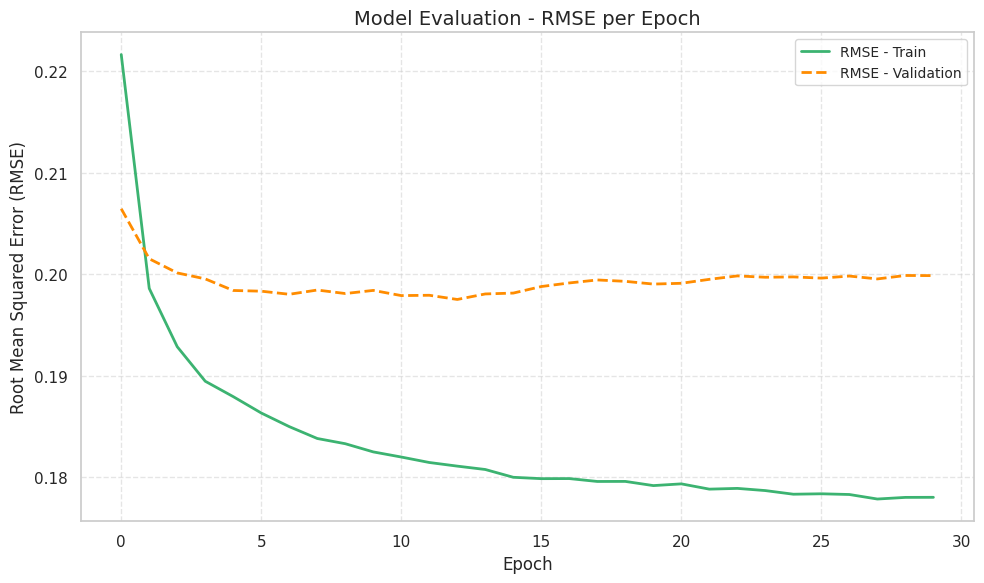

In [48]:
# Membuat plot
plt.figure(figsize=(10, 6))
plt.plot(history.history['root_mean_squared_error'], label='RMSE - Train', color='mediumseagreen', linewidth=2)
plt.plot(history.history['val_root_mean_squared_error'], label='RMSE - Validation', color='darkorange', linestyle='--', linewidth=2)

# Menambahkan judul dan label sumbu
plt.title('Model Evaluation - RMSE per Epoch', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Root Mean Squared Error (RMSE)', fontsize=12)

# Menambahkan grid dan legenda
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='upper right', fontsize=10)

# Menampilkan plot
plt.tight_layout()
plt.show()


Visualisasi grafik root mean square error

In [41]:
# Ambil satu userId secara acak dari data
user_id = merged_df['userId'].sample(1).iloc[0]

# Ambil daftar film yang sudah ditonton oleh user tersebut
movies_watched_by_user = merged_df[merged_df.userId == user_id]

# Ambil daftar film yang belum ditonton oleh user tersebut
movies_not_watched = merged_df[
    ~merged_df['movieId'].isin(movies_watched_by_user['movieId'].values)
][['movieId']].drop_duplicates()

# Filter hanya movieId yang terdapat dalam kamus encoding
movies_not_watched = movies_not_watched[
    movies_not_watched['movieId'].isin(movie_to_movie_encoded.keys())
]

# Encode movieId menjadi indeks numerik
movies_not_watched_encoded = [
    [movie_to_movie_encoded[movie_id]] for movie_id in movies_not_watched['movieId'].values
]

# Encode userId menjadi indeks numerik
user_encoded = user_to_user_encoded.get(user_id)

# Buat array pasangan userId dan setiap movieId yang belum ditonton
user_movie_array = np.hstack((
    np.array([[user_encoded]] * len(movies_not_watched_encoded)),
    np.array(movies_not_watched_encoded)
))

In [42]:
# Prediksi rating
rating = model.predict(user_movie_array).flatten()

# Ambil indeks top-10 prediksi tertinggi
top_indices = rating.argsort()[-10:][::-1]

# Ambil movieId dari encoded
recommended_movie_ids = [
    movie_encoded_to_movie[i[0]] for i in np.array(movies_not_watched_encoded)[top_indices]
]

# Ambil judul dan genre film dari movieId rekomendasi
recommended_movies = merged_df[merged_df['movieId'].isin(recommended_movie_ids)][['movieId', 'title', 'genres']].drop_duplicates()
print(recommended_movies)

284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
       movieId                                              title  \
248      80906                                  Inside Job (2010)   
249      86345                       Louis C.K.: Hilarious (2010)   
265        720  Wallace & Gromit: The Best of Aardman Animatio...   
1011     37741                                      Capote (2005)   
1074       187                                  Party Girl (1995)   
1078       922      Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)   
1081      1095                         Glengarry Glen Ross (1992)   
1089      2300                              Producers, The (1968)   
1093      3328           Ghost Dog: The Way of the Samurai (1999)   
16258     1178                              Paths of Glory (1957)   

                           genres  
248                   Documentary  
249                        Comedy  
265    Adventure|Animation|Comedy  
1011                  Crime|Drama  
1074             

Mensimulaskan rekomendasi 10 film terbaik untuk satu pengguna yang dipilih secara acak berdasarkan model collaborative filtering, dan berhasil.

# Evaluation

## Content Based Filtering - Precision



**Precision** adalah matriks evaluasi kinerja model sistem rekomendasi yang mengukur seberapa banyak rekomendasi yang diberikan oleh sistem benar-benar relevan atau sesuai dengan preferensi pengguna. Secara matematis :

$$
\text{Precision} = \frac{\text{Jumlah item relevan yang direkomendasikan}}{\text{Jumlah total item yang direkomendasikan}}
$$
---


In [50]:
target_genres = set(['Adventure', 'Children', 'Fantasy'])

# mengambil rekomendasi
recommendations = movie_recommendations('Toy Story (1995)')

# Fungsi cek relevansi
def is_relevant(genre_str, target_genres):
    genres = set(genre_str.split('|'))
    return target_genres.issubset(genres)

# menghitung precision
total_recs = len(recommendations)
relevant_recs = recommendations['genres'].apply(lambda x: is_relevant(x, target_genres)).sum()

precision = relevant_recs / total_recs if total_recs > 0 else 0

print(f"Precision: {precision:.2f}")

Precision: 1.00


Sistem rekomendasi yang dibangun menggunakan metode Content-Based Filtering berhasil mencapai nilai evaluasi precision sebesar 100%. Capaian ini menunjukkan bahwa algoritma mampu merekomendasikan film dengan tingkat akurasi yang sangat tinggi, khususnya dalam mencocokkan genre antara film yang direkomendasikan dengan preferensi pengguna. Hasil ini mencerminkan efektivitas pendekatan content-based dalam menghasilkan rekomendasi yang relevan dan sesuai dengan karakteristik konten film.

## Collaborative Filtering - RMSE


**Root Mean Squared Error (RMSE)** dipilih sebagai metrik evaluasi untukmodel collaborative filtering ini. RMSE memberikan gambaran seberapa besar rata-rata kesalahan prediksi model dibandingkan rating asli dari pengguna, dengan satuan yang sama seperti rating.

Rumus RMSE:

$$
\text{RMSE} = \sqrt{\frac{1}{N} \sum_{i=1}^N (y_i - \hat{y}_i)^2}
$$

di mana:

- $y_i$ adalah rating asli,
- $\hat{y}_i$ adalah rating prediksi,
- $N$ adalah jumlah data.

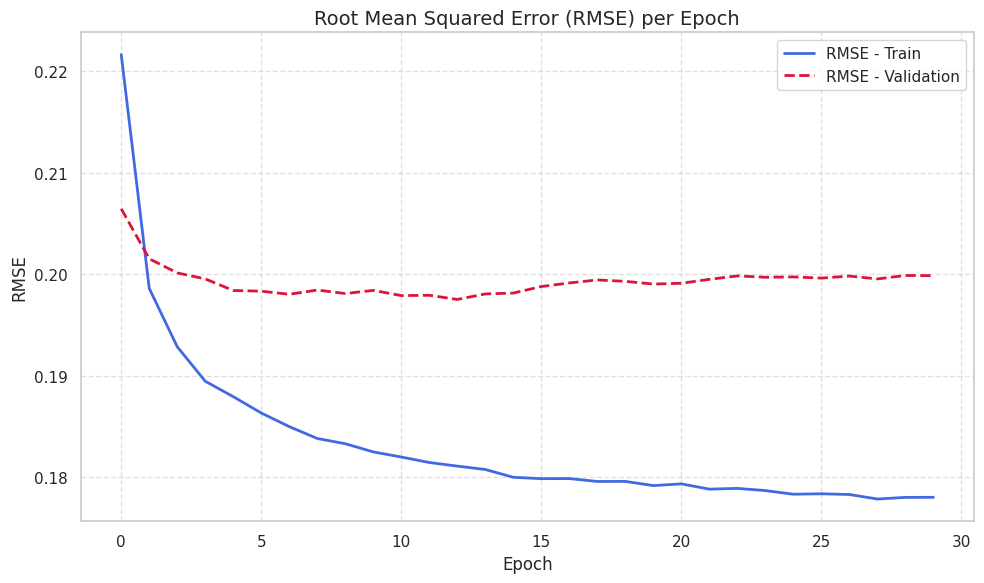

Final RMSE (Train): 0.1780
Final RMSE (Validation): 0.1999


In [47]:
# Plot RMSE
plt.figure(figsize=(10, 6))
plt.plot(history.history['root_mean_squared_error'], label='RMSE - Train', color='royalblue', linewidth=2)
plt.plot(history.history['val_root_mean_squared_error'], label='RMSE - Validation', color='crimson', linestyle='--', linewidth=2)
plt.title('Root Mean Squared Error (RMSE) per Epoch', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Menampilkan nilai RMSE akhir untuk Train dan Validation
final_rmse_train = history.history['root_mean_squared_error'][-1]
final_rmse_val = history.history['val_root_mean_squared_error'][-1]

print(f"Final RMSE (Train): {final_rmse_train:.4f}")
print(f"Final RMSE (Validation): {final_rmse_val:.4f}")


Model Collaborative Filtering menunjukkan performa yang baik dengan nilai RMSE akhir sebesar 0.1780 pada data pelatihan (Train), yang mengindikasikan bahwa model mampu memprediksi rating film dengan rata-rata kesalahan sekitar 0.18 poin. Ini menunjukkan bahwa model telah berhasil mempelajari pola dari data training dengan cukup akurat. Sementara itu, pada data validasi, model mencatat nilai RMSE sebesar 0.1999, hanya sedikit lebih tinggi dari data pelatihan, yang menandakan kemampuan generalisasi model yang baik serta minimnya overfitting. Secara keseluruhan, RMSE di bawah 0.3 pada skala rating 1–5 membuktikan bahwa model cukup akurat dan andal dalam merekomendasikan film yang sesuai dengan preferensi pengguna.